## Pricing a European Call Option: CPU vs GPU and CUDA vs JAX.

#### Author: [John Stachurski](http://johnstachurski.net/)
#### Date: Nov 2022

In this notebook we implement a simple task on the CPU and the GPU.  The task is estimating the risk-neutral price of a call option.  All our code is accelerated by a JIT-compiler, meaning that it runs fast on a single thread.  The main aim is to parallelize the work across multiple threads in the most efficient way.  We start on the CPU, which only has a few threads, and then shift to the GPU.

On the GPU we try a traditional implmentation using Numba-CUDA and a JAX-based implementation.  We will see that the JAX-based implementation is must faster than all others.

While the Numba-CUDA implementation could be improved by thinking more carefully about the underlying hardware, JAX takes care of efficient parallization automatically.

If you want to run this lecture and don't have a configured GPU, you can try it on [Google Colab](https://colab.research.google.com/).

If you have access to your head of department's credit card, I recommend Colab Pro (faster GPUs).

We will use the following imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple

We are going to price a **European call option** under the assumption of risk neutrality.  

Recall that the risk-neutral price of an asset that pays $G_n$ in $n$ periods (one payoff $n$ periods in the future) is 

$$ P = \beta^n \mathbb E G_n $$

where $\beta$ is a discount factor.

For a European call option on with expiry at time $n$ and strike price $K$, the payoff is 

$$ G_n = \max\{S_n - K, 0\} $$

where $S_n$ is the price of the stock at time $n$.

Thus, the risk-neutral price is

$$ P = \beta^n \mathbb E \max\{ S_n - K, 0 \} $$

(For example, if the call option is to buy stock in Amazon at strike price $K$, the owner has the right to buy 1 share in Amazon at price $K$ after $n$ days.  The price is the expectation of the return $\max\{S_n - K, 0\}$, discounted to current value.)

## Lognormal Example

Let's start with an easy case where $S_n$ has a known distribution.

Suppose in particular that $S_n$ has the [log-normal](https://en.wikipedia.org/wiki/Log-normal_distribution) distribution with parameters $\mu$ and $\sigma$.  Let $f$ denote the density of this distribution.  

Then

$$ P = \beta^n \int_0^\infty g(x) dx $$

where

$$g(x) := \max\{x - K, 0\} f(x)$$ 

Let's plot $g$ over the interval $[0, 400]$ when

In [2]:
μ, σ, β, n, K = 4, 0.25, 0.99, 10, 40

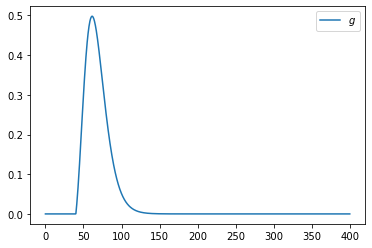

In [3]:
from scipy.stats import lognorm

def f(x):
    "Lognormal density."
    return lognorm.pdf(x, σ, scale=np.exp(μ))

def g(x):
    return np.maximum(x - K, 0) * f(x)

x_grid = np.linspace(0, 400, 1_000)
y_grid = g(x_grid) 

fig, ax = plt.subplots()
ax.plot(x_grid, y_grid, label="$g$")
ax.legend()
plt.show()

### Integration with Quadrature

We can integrate numerically using quadrature to obtain the price:

In [4]:
from scipy.integrate import quad

integral, error = quad(g, 0, 1_000)
P = β**n * integral 
print(f"The numerical integration based option price is {P:.3f}")

The numerical integration based option price is 15.188


### Integration via Monte Carlo

We can get a similar result using Monte Carlo to compute the expectation term in the option price, rather than `quad`.

We use the fact that if $S_n^1, \ldots, S_n^M$ are independent draws from the lognormal distribution specified above, then, by the law of large numbers,

$$ \mathbb E \max\{ S_n - K, 0 \} 
    \approx
    \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
    $$
  

In [5]:
M = 10_000_000
S = np.exp(μ + σ * np.random.randn(M))
payoffs = np.maximum(S - K, 0)
P = β**n * payoffs.mean()
print(f"The Monte Carlo option price is {P:.3f}")

The Monte Carlo option price is 15.195


## A Model with Stochastic Volatility

In the last example we had a known distribution for $S_n$.

Now let's investigate a more realistic model, where we begin by specifying the underlying dynamics.

One common model for $\{S_t\}$ is

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma \xi_{t+1} $$

where $\{ \xi_t \}$ is IID and standard normal.  However, its predictions are counterfactual because volatility is not stationary but rather changes over time.  

Here is an improved version:

$$ \ln \frac{S_{t+1}}{S_t} = \mu + \sigma_t \xi_{t+1} $$

where 

$$ 
    \sigma_t = \exp(h_t), 
    \quad
        h_{t+1} = \rho h_t + \nu \eta_{t+1}
$$

Here $\{\eta_t\}$ is also IID and standard normal.

Putting this together, with $s_t := \ln S_t$, the dynamics become

$$
\begin{aligned}
s_{t+1} & = s_t + \mu + \exp(h_t) \xi_{t+1}\\
h_{t+1} & = \rho h_t + \nu \eta_{t+1}
\end{aligned}
$$

### Default Specification

We use a namedtuple for storing parameters and initial conditions

In [6]:
Model = namedtuple("Model", 
                   ("β", "μ", "K", "n", "ρ", "ν", "S0", "h0"))

Here's a function to create an instance of `Model` with a set of default parameters.

In [7]:
def create_model(β=0.95,     # discount factor
                 μ=0.0001,   # mean price growth rate
                 K=100,      # strike price
                 n=10,       # expiry
                 ρ=0.1,      # volatility correlation
                 ν=0.001,    # volatility of volatility
                 S0=10,      # initial S
                 h0=0):      # inital h

    return Model(β=β, μ=μ, K=K, n=n, ρ=ρ, ν=ν, S0=S0, h0=h0)

Let's create a default instance to use below.

In [8]:
default_model = create_model()

### Visualizing Paths




Here is a function to simulate a path for prices.

In [9]:
from numpy.random import randn

def simulate_asset_price_path(model):
    
    β, μ, K, n, ρ, ν, S0, h0 = model
    s = np.empty(n+1)
    s[0] = np.log(S0)

    h = h0
    for t in range(n):
        s[t+1] = s[t] + μ + np.exp(h) * randn()
        h = ρ * h + ν * randn()
        
    return np.exp(s)

Here we plot some paths and the log of the paths.

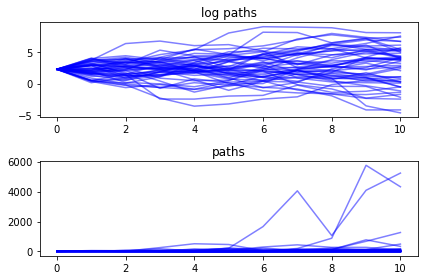

In [10]:
fig, axes = plt.subplots(2, 1)

titles = 'log paths', 'paths'
transforms = np.log, lambda x: x
for ax, transform, title in zip(axes, transforms, titles):
    for i in range(50):
        path = simulate_asset_price_path(default_model)
        ax.plot(transform(path), 'b-', alpha=0.5)
    ax.set_title(title)
    
fig.tight_layout()
plt.show()

### Monte Carlo Computation via Numba

Now we compute the price of the option $P$ by Monte Carlo, averaging over realizations $S_n^1, \ldots, S_n^M$ of $S_n$ and appealing to the law of large numbers:

$$
\begin{aligned}
P & = \beta^n \mathbb E \max\{ S_n - K, 0 \} 
  \\
  &\approx
    \beta^n \frac{1}{M} \sum_{m=1}^M \max \{S_n^m - K, 0 \}
\end{aligned}
$$
    


In [11]:
from numba import njit
default_M = 20_000_000

In [12]:
@njit
def compute_call_price(model, M=default_M):
    """
    Generate M observations of S_n and average to estimate
    the option price.
    """

    # Set up
    β, μ, K, n, ρ, ν, S0, h0 = model
    current_sum = 0.0
    
    # For each sample path
    for m in range(M):
        s = np.log(S0)
        h = h0
        
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
            
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n * current_sum / M

Let's time it.

In [13]:
%%time 
compute_call_price(default_model)

CPU times: user 10.1 s, sys: 7.08 ms, total: 10.1 s
Wall time: 10.1 s


838.4871579285684

We'll call it again to exclude compile time.

In [14]:
%%time 
compute_call_price(default_model)

CPU times: user 10.3 s, sys: 52.6 ms, total: 10.4 s
Wall time: 10.2 s


869.2102128128225

### Acceleration via `prange`

Let's use `prange` from Numba to parallelize this codeand make it faster.

Note that, at this stage, parallelization targets host chips (onboard CPUs), not the GPU.

In [15]:
from numba import prange

In [16]:
@njit(parallel=True)
def compute_call_price_parallel(model, M=default_M):

    β, μ, K, n, ρ, ν, S0, h0 = model

    current_sum = 0.0
    # For each sample path
    for m in prange(M):      # Note use of prange
        s = np.log(S0)
        h = h0
        # Simulate forward in time
        for t in range(n):
            s = s + μ + np.exp(h) * randn()
            h = ρ * h + ν * randn()
        # And add the value max{S_n - K, 0} to current_sum
        current_sum += np.maximum(np.exp(s) - K, 0)
        
    return β**n * current_sum / M

In [17]:
%%time
compute_call_price_parallel(default_model)

CPU times: user 15.2 s, sys: 36 ms, total: 15.3 s
Wall time: 2.5 s


856.8948485567332

In [18]:
%%time
compute_call_price_parallel(default_model)

CPU times: user 14.8 s, sys: 19.4 ms, total: 14.8 s
Wall time: 2.03 s


873.4848984973764

### A GPU Implementation Using CUDA

Next we will use a GPU implmentation using CUDA, which is an interface to GPU programming designed by Nvidia.  Rather than using CUDA directly, which requires C, we use a Numba-based front end --- which is just as fast, if not faster.

If you are using Colab, you need to first need to make Numba aware of the location of certain libraries.  Uncomment the next two cells.

In [19]:
#!find / -iname 'libdevice'
#!find / -iname 'libnvvm.so'

Change `cuda-xxx` to the version displayed.

In [20]:
#import os
#os.environ['NUMBAPRO_LIBDEVICE'] = "/usr/local/cuda-11.2/nvvm/libdevice"
#os.environ['NUMBAPRO_NVVM'] = "/usr/local/cuda-11.2/nvvm/lib64/libnvvm.so"

We use the following libraries.

In [21]:
from math import log, exp
from numba import cuda, objmode, float32, int32
from numba.cuda.random import xoroshiro128p_normal_float32 as xnf32
from numba.cuda.random import create_xoroshiro128p_states as x128_states

GPUs typically operate on 32 bit floats so we use the following function to convert as required.

In [22]:
def convert_to_32_bit(scalar):
    "Convert scalar to 32 bits.  Must be a float or integer."
    if isinstance(scalar, float):
        return float32(scalar)
    return(int32(scalar))    

Here's a function to update the log price of the asset and the volatility term by one period.

In [23]:
@cuda.jit(device=True)
def update_price(params, s, h, ξ_1, ξ_2):
    "Update the state given standard normal draws ξ_1 and ξ_2."
    β, μ, K, n, ρ, ν = params
    s = s + μ + exp(h) * ξ_1
    h = ρ * h + ν * ξ_2
    return s, h

Now we write a **kernel** function, which describes the task of a single thread on the GPU.

In [24]:
@cuda.jit
def price_generation_kernel(params, init_vals, price_sample, rng_states):
    """
    Kernel function for the GPU.  Produces one Monte Carlo observation of S_n.
    
    This draw of S_n will be written into a slot in the array `price_sample` 
    specific to each thread.
    """

    # Get position and unpack parameter values
    pos = cuda.grid(1)
    β, μ, K, n, ρ, ν = params
    S0, h0 = init_vals
    
    s, h = log(S0), h0
    for t in range(n):

        # Draw shocks and then update price
        ξ_1 = xnf32(rng_states, pos)
        ξ_2 = xnf32(rng_states, pos)
        s, h = update_price(params, s, h, ξ_1, ξ_2)

    price_sample[pos] = exp(s)

Next we create a host function that allocates memory on the device, launches the kernel, collects the output and returns an estimate of the option price.

In [25]:
def compute_call_price_cuda(model,
                            M=default_M,
                            seed=1234, 
                            threads_per_block=132):
    """
    This function launches the kernel and returns a 
    Monte Carlo estimate of the price
    """
    # Set up
    nthreads = threads_per_block
    nblocks = M // nthreads
    β, μ, K, n, ρ, ν, S0, h0 = model
    params = tuple(map(convert_to_32_bit, (β, μ, K, n, ρ, ν)))
    init_vals = tuple(map(convert_to_32_bit, (S0, h0)))

    # Generate the random states
    rng_states = x128_states(M, seed=seed)

    # Allocate memory
    price_sample = cuda.to_device(np.zeros(M))

    # Launch kernel and compute prices
    price_generation_kernel[nblocks, nthreads](
        params, init_vals, price_sample, rng_states
    )

    # Compute average payoff and discount
    price_sample = price_sample.copy_to_host()
    payoffs = np.maximum(price_sample - K, 0)
    return β**n * np.mean(payoffs)

In [26]:
%%time
compute_call_price_cuda(default_model)

CPU times: user 5.02 s, sys: 180 ms, total: 5.2 s
Wall time: 5.24 s


849.0907210556882

This result is disappointing.  The main issue is that the kernel performs a very small task, so the overhead of parallelization exceeds the speed gains.

We could try to reoptimize this --- or we could just use JAX and let Google's engineers do the job for us.

## JAX Version

In [27]:
import jax
import jax.numpy as jnp

Our JAX-based function keeps track of all $M$ prices at once and shifts them forward in time over $n$ steps.  Then it computes the sample mean and the option price.

In [28]:

def compute_call_price_jax(model=default_model,
                           M=default_M,
                           key=jax.random.PRNGKey(1)):
    """
    Estimate the price of the call option using Monte Carlo.
    """
    
    β, μ, K, n, ρ, ν, S0, h0 = model

    s = jnp.full(M, jnp.log(S0))
    h = jnp.full(M, h0)
    for t in range(n):
        key, subkey = jax.random.split(key)
        Z = jax.random.normal(subkey, (2, M))
        s = s + μ + jnp.exp(h) * Z[0, :]
        h = ρ * h + ν * Z[1, :]
    expectation = jnp.mean(jnp.maximum(jnp.exp(s) - K, 0))
        
    return β**n * expectation

In [29]:
%%time 
compute_call_price_jax().block_until_ready()

CPU times: user 696 ms, sys: 36.4 ms, total: 733 ms
Wall time: 957 ms


DeviceArray(883.57184, dtype=float32)

In [30]:
%%time 
compute_call_price_jax().block_until_ready()

CPU times: user 23.1 ms, sys: 8.01 ms, total: 31.1 ms
Wall time: 44.7 ms


DeviceArray(883.57184, dtype=float32)

We can do even better by using JAX to JIT-compile the function.

In [31]:
compute_call_price_jax_jit = jax.jit(compute_call_price_jax)

Let's time it.

In [32]:
%%time 
compute_call_price_jax_jit().block_until_ready()

CPU times: user 1.23 s, sys: 55.9 ms, total: 1.29 s
Wall time: 1.64 s


DeviceArray(883.57184, dtype=float32)

Now here's the timing after compilation is complete:

In [33]:
%%time 
compute_call_price_jax_jit().block_until_ready()

CPU times: user 3.32 ms, sys: 21 µs, total: 3.34 ms
Wall time: 21.4 ms


DeviceArray(883.57184, dtype=float32)